In [1]:
from pathlib import Path

import earthkit.data
import earthkit.plots
import numcodecs
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
from numcodecs.abc import Codec
from numcodecs_combinators.stack import CodecStack
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_safeguards.lossless import BytesCodec
from numcodecs_wasm_zfp import Zfp
from numcodecs_wasm_zfp_classic import ZfpClassic

In [2]:
t2m = xr.open_dataset(
    Path() / "data" / "era5-daily-2tm-2024-01" / "data.nc",
    engine="netcdf4",
    decode_timedelta=True,
).t2m.chunk({"valid_time": 1})
t2m

<xarray.DataArray 't2m' (valid_time: 31, latitude: 721, longitude: 1440)> Size: 129MB
dask.array<xarray-<this-array>, shape=(31, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * valid_time  (valid_time) datetime64[ns] 248B 2024-01-01 ... 2024-01-31
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [3]:
vmin, vmax = int(np.floor(np.amin(t2m))), int(np.ceil(np.amax(t2m)))
vmin, vmax

(217, 316)

In [4]:
from numcodecs_observers import observe
from numcodecs_observers.bytesize import BytesizeObserver
from numcodecs_observers.hash import HashableCodec

In [5]:
zfp_classic = CodecStack(ZfpClassic(mode="fixed-accuracy", tolerance=1.0))

bytesize = BytesizeObserver()
with observe(zfp_classic, observers=[bytesize]) as codec:
    decoded_zfp_classic = codec.encode_decode_data_array(t2m).compute()

In [6]:
(
    sum(bs.pre for bs in bytesize.encode_sizes[HashableCodec(zfp_classic[0])]) /
    sum(bs.post for bs in bytesize.encode_sizes[HashableCodec(zfp_classic[0])])
)

9.092469660812577

In [35]:
with xr.set_options(keep_attrs=True):
    error_zfp_classic = (decoded_zfp_classic - t2m).mean(dim="valid_time").compute()
float(np.mean(error_zfp_classic) / np.std(error_zfp_classic)), float(np.mean(error_zfp_classic))

(-0.2028914988040924, -0.006122771184891462)

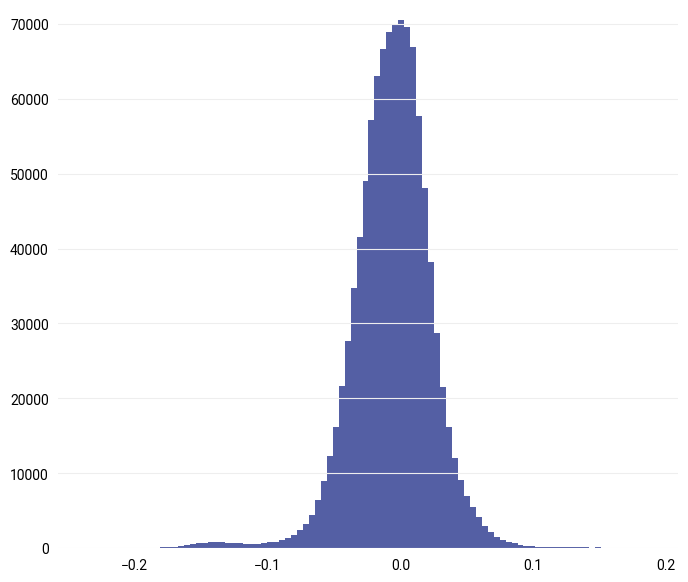

In [8]:
plt.hist(error_zfp_classic.values.flatten(), bins=100)
plt.show()

In [9]:
emin, emax = float(np.amin(error_zfp_classic)), float(np.amax(error_zfp_classic))
emin, emax

(-0.24820241332054138, 0.20027554035186768)

/workspaces/numcodecs-safeguards/.venv/lib/python3.10/site-packages/earthkit/plots/quickplot.py:141: UserWarning: Failed to execute title on given data with: 
unsupported format string passed to NoneType.__format__

consider constructing the plot manually.
  warnings.warn(


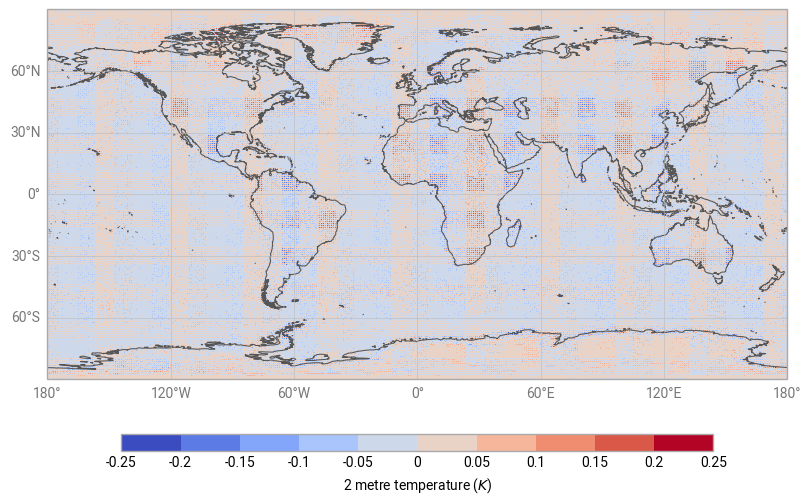

In [10]:
earthkit.plots.quickplot(
    error_zfp_classic,
    style=earthkit.plots.Style(levels=np.linspace(-0.25, 0.25, 11), colors="coolwarm"),
    methods="pcolormesh",
);

In [11]:
mean_error_zfp_classic = float((decoded_zfp_classic - t2m).mean().compute())
mean_error_zfp_classic

-0.0061227697879076

In [36]:
with xr.set_options(keep_attrs=True):
    error_zfp_classic2 = ((decoded_zfp_classic - mean_error_zfp_classic) - t2m).mean(dim="valid_time").compute()
float(np.mean(error_zfp_classic2) / np.std(error_zfp_classic2)), float(np.mean(error_zfp_classic2))

(0.00026294426061213017, 7.934631867101416e-06)

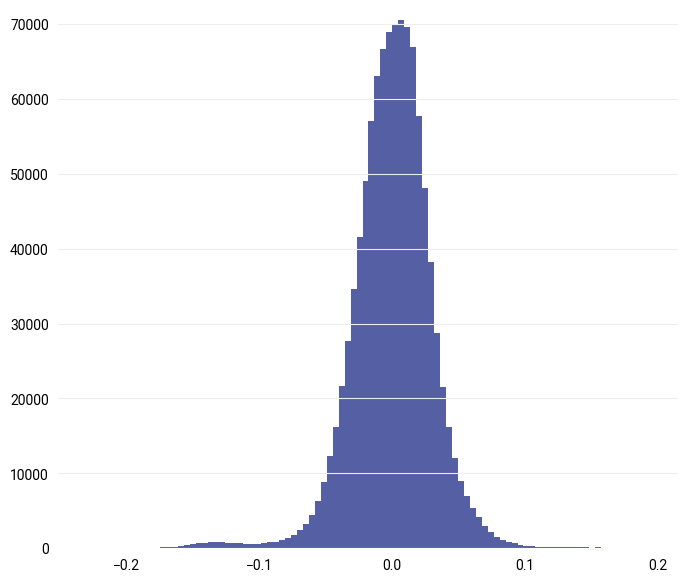

In [15]:
plt.hist(error_zfp_classic2.values.flatten(), bins=100)
plt.show()

In [17]:
from numcodecs_wasm_fixed_offset_scale import FixedOffsetScale

In [20]:
class Foo(Codec):
    codec_id = "foo"

    def encode(self, buf):
        return buf

    def decode(self, buf, out=None):
        return numcodecs.compat.ndarray_copy(buf - mean_error_zfp_classic, out)

In [22]:
zfp_sg = CodecStack(
    SafeguardsCodec(
        codec=CodecStack(
            Foo(),
            ZfpClassic(mode="fixed-accuracy", tolerance=1.0),
        ),
        safeguards=[
            dict(kind="abs", eb_abs=1.0),
            dict(kind="bias"),
        ],
    )
)

bytesize = BytesizeObserver()
with observe(zfp_sg, observers=[bytesize]) as codec:
    decoded_zfp_sg = codec.encode_decode_data_array(t2m).compute()

In [28]:
zfp = CodecStack(Zfp(mode="fixed-accuracy", tolerance=1.0))

decoded_zfp = zfp.encode_decode_data_array(t2m).compute()

In [37]:
with xr.set_options(keep_attrs=True):
    error_zfp = (decoded_zfp - t2m).mean(dim="valid_time").compute()
float(np.mean(error_zfp) / np.std(error_zfp)), float(np.mean(error_zfp))

(-0.0018335387576371431, -5.664207128575072e-05)

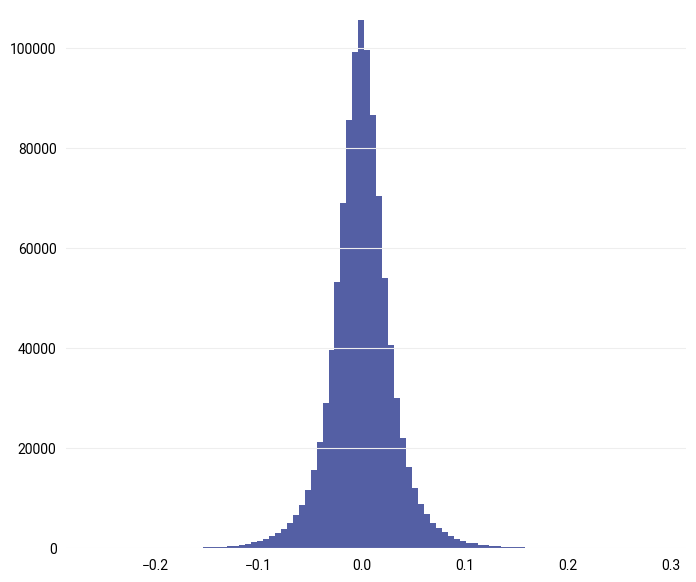

In [30]:
plt.hist(error_zfp.values.flatten(), bins=100)
plt.show()

In [31]:
emin, emax = float(np.amin(error_zfp)), float(np.amax(error_zfp))
emin, emax

(-0.2752527892589569, 0.3035268485546112)

/workspaces/numcodecs-safeguards/.venv/lib/python3.10/site-packages/earthkit/plots/quickplot.py:141: UserWarning: Failed to execute title on given data with: 
unsupported format string passed to NoneType.__format__

consider constructing the plot manually.
  warnings.warn(


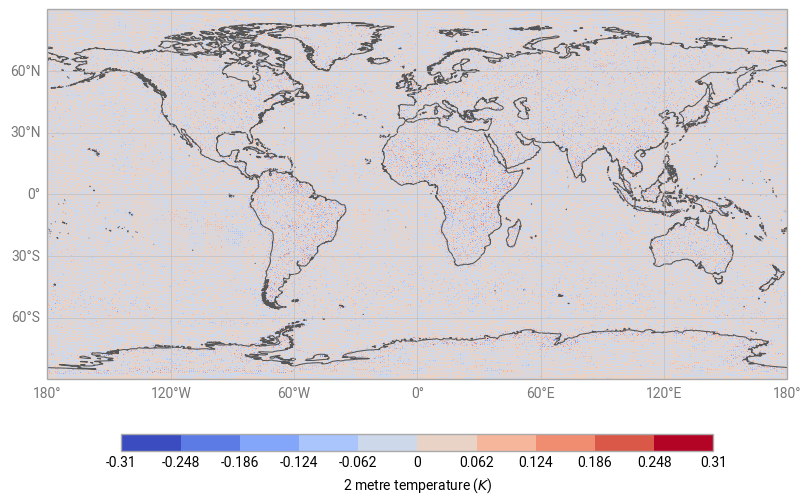

In [32]:
earthkit.plots.quickplot(
    error_zfp,
    style=earthkit.plots.Style(levels=np.linspace(-0.31, 0.31, 11), colors="coolwarm"),
    methods="pcolormesh",
);

In [ ]:
zfp_sg = CodecStack(
    SafeguardsCodec(
        codec=ZfpClassic(mode="fixed-accuracy", tolerance=1.0),
        safeguards=[
            dict(kind="abs", eb_abs=1.0),
            dict(kind="bias"),
            dict(kind="bias"),
            dict(kind="bias"),
        ],
    )
)

bytesize = BytesizeObserver()
with observe(zfp_sg, observers=[bytesize]) as codec:
    decoded_zfp_sg = codec.encode_decode_data_array(t2m).compute()

In [ ]:
list(bytesize.encode_sizes.keys())[-1]

In [23]:
(
    sum(bs.pre for bs in list(bytesize.encode_sizes.values())[-1]) /
    sum(bs.post for bs in list(bytesize.encode_sizes.values())[-1])
)

5.998862123579344

In [38]:
with xr.set_options(keep_attrs=True):
    error_zfp_sg = (decoded_zfp_sg - t2m).mean(dim="valid_time").compute()
float(np.mean(error_zfp_sg) / np.std(error_zfp_sg)), float(np.mean(error_zfp_sg))

(0.013184554874897003, 0.0011407907586544752)

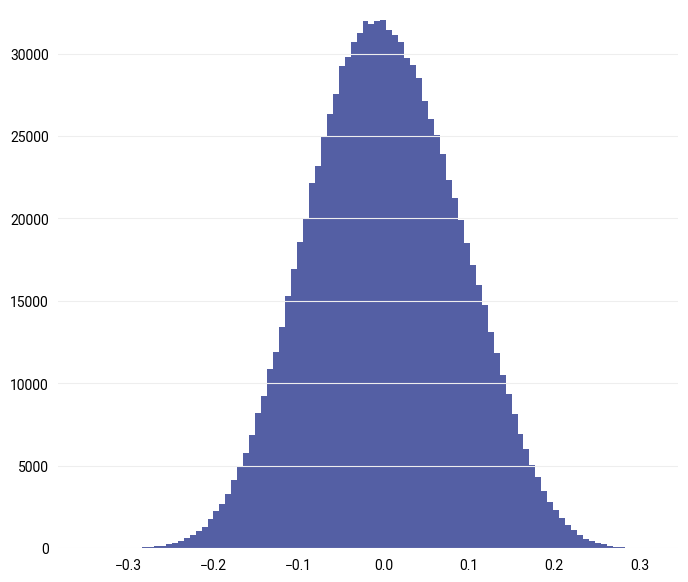

In [25]:
plt.hist(error_zfp_sg.values.flatten(), bins=100)
plt.show()

In [26]:
emin, emax = float(np.amin(error_zfp_sg)), float(np.amax(error_zfp_sg))
emin, emax

(-0.36840033531188965, 0.3319889307022095)

/workspaces/numcodecs-safeguards/.venv/lib/python3.10/site-packages/earthkit/plots/quickplot.py:141: UserWarning: Failed to execute title on given data with: 
unsupported format string passed to NoneType.__format__

consider constructing the plot manually.
  warnings.warn(


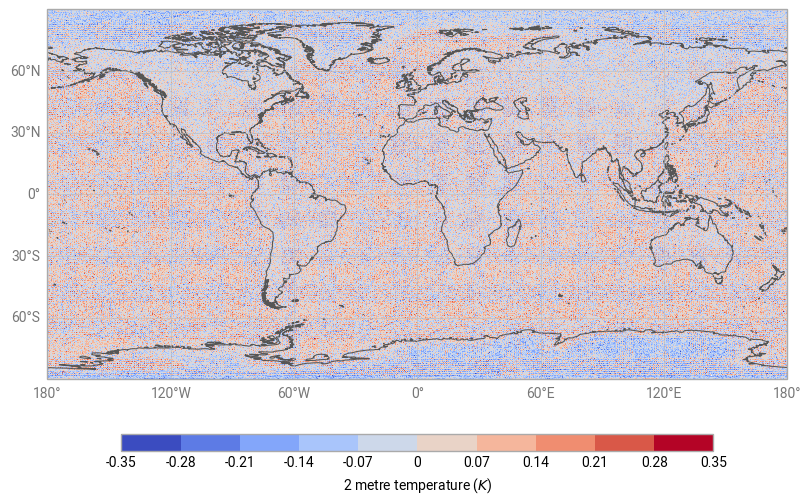

In [27]:
earthkit.plots.quickplot(
    error_zfp_sg,
    style=earthkit.plots.Style(levels=np.linspace(-0.35, 0.35, 11), colors="coolwarm"),
    methods="pcolormesh",
);

In [ ]:
class BiasedLinearQuantizer(Codec):
    codec_id = "biased-linear-quantizer"

    def __init__(self, precision):
        self.precision = precision

    def encode(self, buf):
        return np.floor(buf / self.precision) * self.precision

    def decode(self, buf, out=None):
        return numcodecs.compat.ndarray_copy(buf, out)

In [ ]:
blq = CodecStack(BiasedLinearQuantizer(precision=1.0))

decoded_blq = blq.encode_decode_data_array(t2m).compute()

In [ ]:
with xr.set_options(keep_attrs=True):
    error_blq = (decoded_blq - t2m).mean(dim="valid_time").compute()
float(np.mean(error_blq) / np.std(error_blq))

In [ ]:
plt.hist(error_blq.values.flatten(), bins=100)
plt.show()

In [ ]:
emin, emax = float(np.amin(error_blq)), float(np.amax(error_blq))
emin, emax

In [ ]:
earthkit.plots.quickplot(
    error_blq,
    style=earthkit.plots.Style(levels=np.linspace(-0.83, 0.83, 11), colors="coolwarm"),
    methods="pcolormesh",
);

In [ ]:
blq_sg = CodecStack(
    SafeguardsCodec(
        codec=CodecStack(
            BiasedLinearQuantizer(precision=1.0),
            BytesCodec(),
        ),
        safeguards=[
            dict(kind="abs", eb_abs=1.0),
            dict(kind="bias"),
        ],
    )
)

decoded_blq_sg = blq_sg.encode_decode_data_array(t2m).compute()

In [ ]:
with xr.set_options(keep_attrs=True):
    error_blq_sg = (decoded_blq_sg - t2m).mean(dim="valid_time").compute()
float(np.mean(error_blq_sg) / np.std(error_blq_sg))

In [ ]:
plt.hist(error_blq_sg.values.flatten(), bins=100)
plt.show()

In [ ]:
emin, emax = float(np.amin(error_blq_sg)), float(np.amax(error_blq_sg))
emin, emax

In [ ]:
earthkit.plots.quickplot(
    error_blq_sg,
    style=earthkit.plots.Style(levels=np.linspace(-0.55, 0.83, 11), colors="coolwarm"),
    methods="pcolormesh",
);